# Image Pre-processing 


In [4]:
""" All the imports needed by the main file """
import cv2 as cv
from utils import get_all_files
import matplotlib.pyplot as plt 

In [5]:
""" Global variables/constants """
files = get_all_files("./dataset")

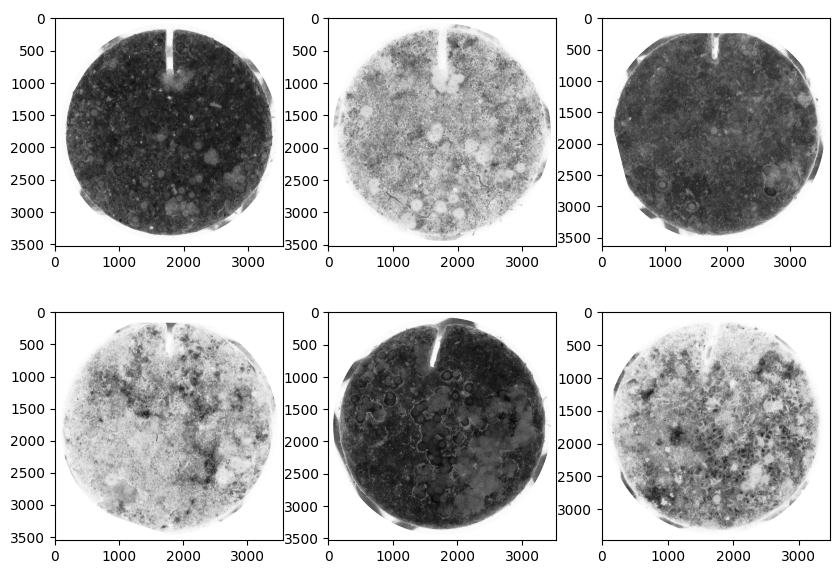

In [6]:
fig = plt.figure(figsize=(10,7))
i = 1
plt.axis("off")
for file in files:
    plt.subplot(2,3,i)
    img = cv.imread(file, cv.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap="Greys")
    i+=1